In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import numpy as np
import torch.nn as nn
import torch
import idx2numpy 
from torchvision.transforms.functional import gaussian_blur
from torch import optim

from matplotlib import pyplot as plt
from deepshape.surfaces import * 

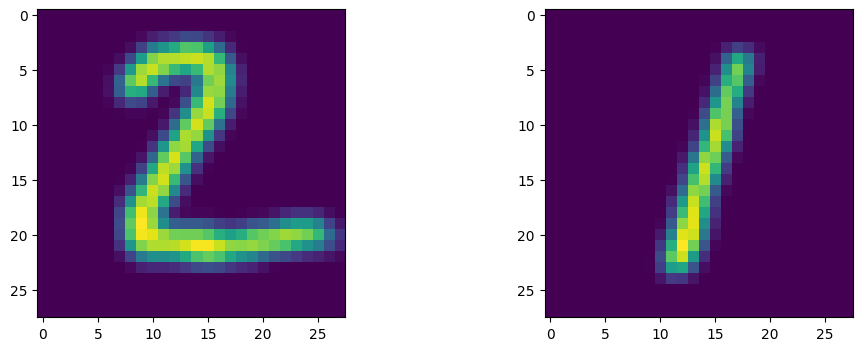

In [3]:
imgfile = "../data/t10k-images.idx3-ubyte"
imgdata = torch.tensor( idx2numpy.convert_from_file(imgfile), dtype=torch.float )
labelfile = "../data/t10k-labels.idx1-ubyte"
labels = torch.tensor( idx2numpy.convert_from_file(labelfile))
imgdata = gaussian_blur(imgdata, [3, 3])
imgdata /= imgdata.max()


img1 = imgdata[1]
img2 = imgdata[2]

fig, (ax1, ax2 )= plt.subplots(1, 2)
ax1.imshow(img1)
ax2.imshow(img2)
plt.show()

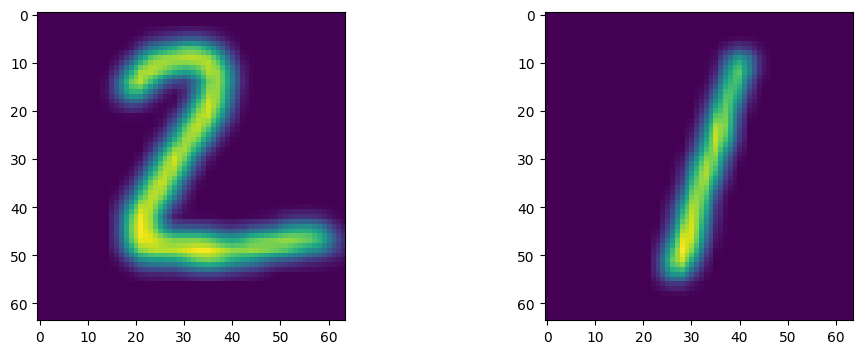

In [4]:
k = 64
f = SingleChannelImageSurface(img1, centering=False, mode='bicubic')
g = SingleChannelImageSurface(img2, centering=False, mode='bicubic')


XX = torch_square_grid(k=k)
X = XX.view(-1, 2)
Zf = f(XX).permute(2, 0, 1).numpy()
Zg = g(XX).permute(2, 0, 1).numpy()

fig, (ax1, ax2 )= plt.subplots(1, 2)
ax1.imshow(Zf[2])
ax2.imshow(Zg[2])
plt.show()

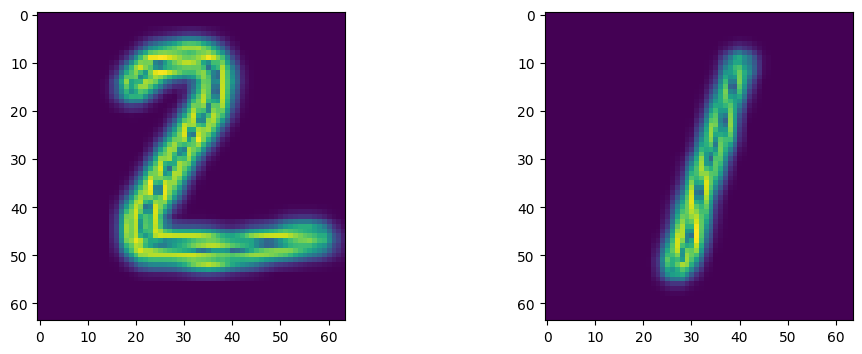

In [5]:
q = Qmap(f)
r = Qmap(g)
Zq = q(XX).permute(2, 0, 1).numpy()
Zr = r(XX).permute(2, 0, 1).numpy()

fig, (ax1, ax2 )= plt.subplots(1, 2)
ax1.imshow(Zq[2])
ax2.imshow(Zr[2])
plt.show()

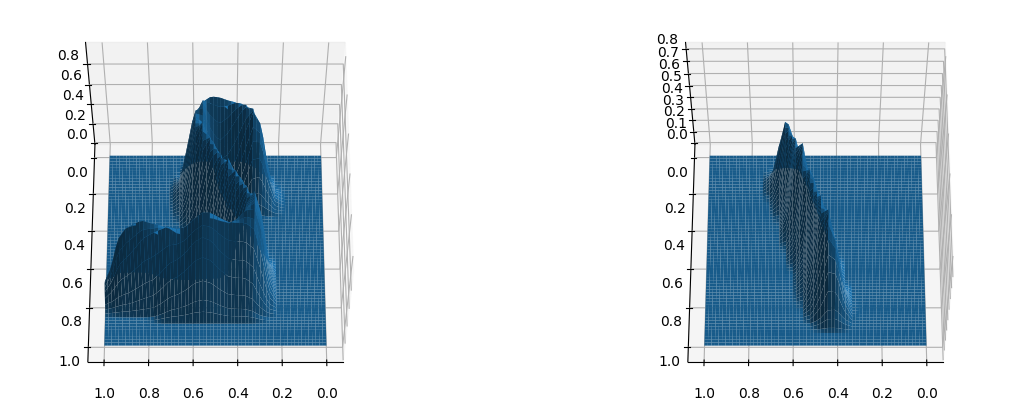

In [6]:
%matplotlib inline
# Init Figure 
fig = plt.figure(figsize=(12, 4))
ax = plt.axes((0., 1., 0.5, 1.), projection='3d')
ax.plot_surface(*Zf, rstride=1, cstride=1)
ax.view_init(+60, -270)
ax = plt.axes((0.5, 1., 0.5, 1.), projection='3d')
ax.plot_surface(*Zg, rstride=1, cstride=1)
ax.view_init(+60, -270)
plt.show(fig)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

# Define reparametrization-network
RN = ReparametrizationNetwork(nn.ModuleList(
    [PalaisLayer(5, init_scale=0., projection_method="eigen") for _ in range(5)]
)).to(device)

loss_func = SingleComponentLoss(q, r, k=64, h=1e-4).to(device)
# loss_func = ShapeDistance(q, r, k=64, h=1e-4).to(device)

# Define optimizer and learning rate scheduler
optimizer = optim.LBFGS(RN.parameters(), lr=1., max_iter=50, line_search_fn="strong_wolfe")
optimizer = optim.SGD(RN.parameters(), lr=1e-2, momentum=0.9)

# Train and store convergence
errors = reparametrize(q, r, RN, loss_func, optimizer, 200, Logger(5), projection_kwargs={"epsilon": 1e-2})#, scheduler=scheduler)

RN.to("cpu"), loss_func.to("cpu");

[Iter     1] loss: 0.554837
[Iter     6] loss: 0.417300
[Iter    11] loss: 0.411269
[Iter    16] loss: 0.342384
[Iter    21] loss: 0.313549
[Iter    26] loss: 0.285410
[Iter    31] loss: 0.261866
[Iter    36] loss: 0.243947
[Iter    41] loss: 0.241407
[Iter    46] loss: 0.282869
[Iter    51] loss: 0.236457
[Iter    56] loss: 0.254346
[Iter    61] loss: 0.225784
[Iter    66] loss: 0.216426
[Iter    71] loss: 0.211035
[Iter    76] loss: 0.222738
[Iter    81] loss: 0.204538
[Iter    86] loss: 0.194967
[Iter    91] loss: 0.201353
[Iter    96] loss: 0.209127
[Iter   101] loss: 0.207784
[Iter   106] loss: 0.220335
[Iter   111] loss: 0.201924
[Iter   116] loss: 0.228207
[Iter   121] loss: 0.230182
[Iter   126] loss: 0.272938
[Iter   131] loss: 0.244776
[Iter   136] loss: 0.216274
[Iter   141] loss: 0.200856
[Iter   146] loss: 0.191364
[Iter   151] loss: 0.213348
[Iter   156] loss: 0.188734
[Iter   161] loss: 0.212222
[Iter   166] loss: 0.187972
[Iter   171] loss: 0.185902
[Iter   176] loss: 0

In [11]:
u(X)[:, [1, 0]]

tensor([[0.0000, 0.0000],
        [0.0000, 0.0228],
        [0.0000, 0.0456],
        ...,
        [1.0000, 0.9215],
        [1.0000, 0.9606],
        [1.0000, 1.0000]], grad_fn=<IndexBackward>)

In [33]:
%matplotlib inline

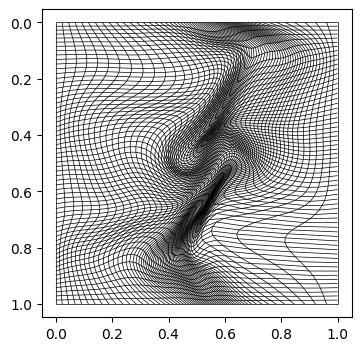

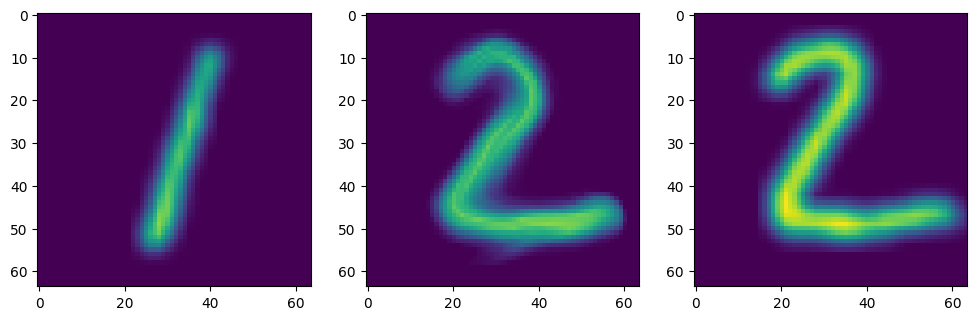

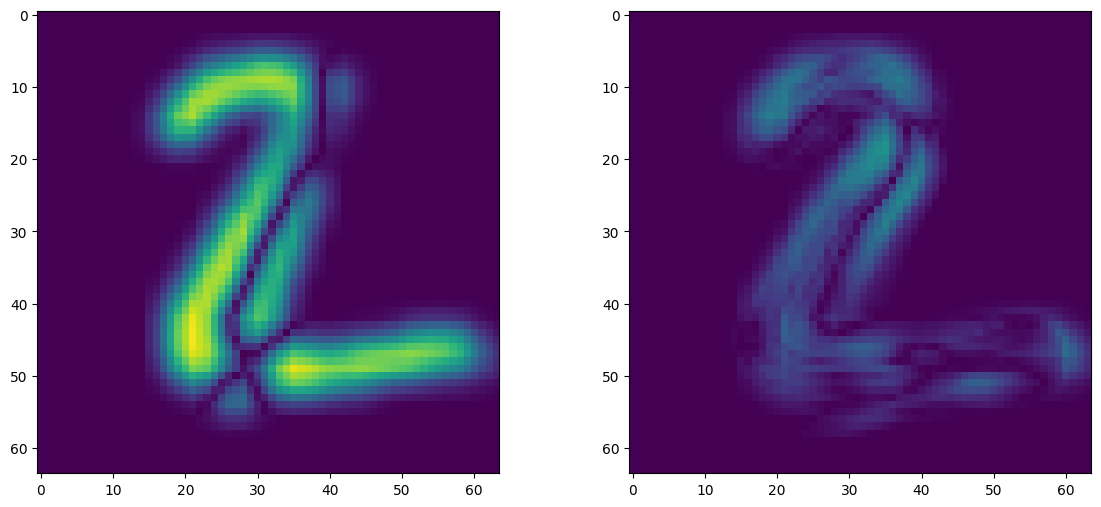

In [34]:
# =============== PLotting below +============
u = lambda x: RN(x)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_diffeomorphism(u, k=64, ax=ax, color="k", lw=0.5)
# plt.gca().invert_xaxis()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.gca().invert_yaxis()
plt.axis("equal")

plt.savefig("/home/jorgen/deepshape/figures/1-2-warp-diffeomorphism.pdf")


fphi = f.compose(u)
gphi = g.compose(u)

Zff = fphi(X).view(k, k, 3).detach().numpy()
Zgg = gphi(X).view(k, k, 3).detach().numpy()

fig, (ax1, ax2 , ax3)= plt.subplots(1, 3)
ax3.imshow(Zf[2], vmin=0., vmax=1.)
ax2.imshow(Zgg[..., 2], vmin=0., vmax=1.)
# plot_diffeomorphism(k=32, ax=ax2)
ax1.imshow(Zg[2],  vmin=0., vmax=1.)
plt.savefig("/home/jorgen/deepshape/figures/1-2-warp.pdf")
plt.show()

fig, (ax1, ax3,)= plt.subplots(1, 2, figsize=(14, 6))
ax1.imshow(np.abs(Zf[2] - Zg[2]), vmin=0., vmax=1.)
# plot_diffeomorphism(u, k=32, ax=ax2)
ax3.imshow(np.abs(Zf[2] - Zgg[..., 2]), vmin=0., vmax=1.)
plt.savefig("/home/jorgen/deepshape/figures/1-2-warp-error.pdf")
plt.show()

### Distance Matrix Compute

In [ ]:
examples_per_digit = 2
digits = torch.empty(10 *  examples_per_digit, 28, 28)
sublabels = torch.empty(10 * examples_per_digit, dtype=int)

for i in range(10):
    start = i * examples_per_digit
    digits[start:start+examples_per_digit] = imgdata[labels == i][:examples_per_digit]
    sublabels[start:start+examples_per_digit] = i

In [13]:
optim_builder = optimizer_builder(torch.optim.LBFGS, lr=0.9, max_iter=50)

# Total number of images
num_images = digits.shape[0]

# Create empty distance matrix
distance_matrix = np.zeros((num_images, num_images))

for i in range(digits.shape[0]):

    print(f"{'=' * 30 } Digit {sublabels[i]} {'=' * 30}")
    
    # Create qmap for current image
    f = SingleChannelImageSurface(digits[i])
    q = Qmap(f)
    
    # Loop thorugh all other images and compare to image i
    for j in range(digits.shape[0]):
        # 0 distance to itself
        if i == j:
            continue
            
        # Define qmap for other image.
        g = SingleChannelImageSurface(digits[j])
        r = Qmap(g)
        
        # Define a new netwrok used for matching.
        rn = ReparametrizationNetwork(nn.ModuleList(
            [PalaisLayer(5) for _ in range(5)]
        ))
        optimizer = optim_builder(rn)
        
        loss = SingleComponentLoss(q, r, k=32, h=3.4e-4)
        
        # Match data
        print(f"{'-'*20} Comparing digits {sublabels[i]} and {sublabels[j]} {'-'*20}")
        reparametrize(q, r, rn, loss, optimizer, 1, Silent())
#         distance_matrix[i, j] = ShapeDistance(q, r, k=32, h=3.4e-4)(rn)
        distance_matrix[i, j] = loss(rn)
        print(f"Loss: {distance_matrix[i, j]:.5f}")
        

============================== Digit 0 ==============================
-------------------- Comparing digits 0 and 0 --------------------

Finished training in 3.45249s
Loss: 0.12257
-------------------- Comparing digits 0 and 1 --------------------

Finished training in 3.42453s
Loss: 0.30317
-------------------- Comparing digits 0 and 1 --------------------

Finished training in 3.32130s
Loss: 0.39216
-------------------- Comparing digits 0 and 2 --------------------

Finished training in 3.31971s
Loss: 0.43070
-------------------- Comparing digits 0 and 2 --------------------

Finished training in 3.32079s
Loss: 0.31395
-------------------- Comparing digits 0 and 3 --------------------

Finished training in 3.65404s
Loss: 0.22671
-------------------- Comparing digits 0 and 3 --------------------

Finished training in 3.37749s
Loss: 0.13637
-------------------- Comparing digits 0 and 4 --------------------

Finished training in 3.33642s
Loss: 0.20622
-------------------- Comparing dig

KeyboardInterrupt: 

In [ ]:
save_distance_matrix('distance_matrix.pickle', distance_matrix, sublabels)

In [ ]:
fig, axes = plt.subplots(10, examples_per_digit, figsize=(14, 20))
for i in range(10):
    for j in range(examples_per_digit):
        axes[i][j].imshow(digits[examples_per_digit * i + j])
        
plt.show()

In [ ]:
plot_distance_matrix(distance_matrix)